In [1]:
import matplotlib.pyplot as plt
from scipy.stats import mode

import seaborn as sns
import numpy as np

from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

sns.set()

聚类算法是一种无监督算法。聚类算法直接从数据的内在性质中学习最优的划分结果或者确定离散标签类型。`k-means`是最容易理解的聚类算法，在`sklearn.cluster.KMeans`中实现。

### 5.11.1 k-means简介
`k-means`算法在不带标签的多维数据集中寻找确定数量的簇。最优的聚类结果需要符合以下两个假设：
+ `簇中心点`(cluster center)是属于该簇的所有数据点坐标的算术平均值
+ 一个簇的每个点到该簇中心点的距离，比到其他簇中心点的距离短

这两个假设是`k-means`模型的基础。

我们通过一个简单的数据集，看看k-means算法的处理结果。

首先，生成一个二维数据集，该数据集包含`4`个明显的簇(由于要演示无监督算法，我们去掉了标签，如`图5-110`)：

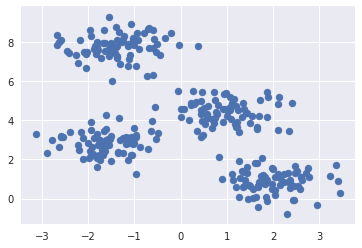

In [2]:
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

`k-means`算法可以自动完成4个簇的识别工作：

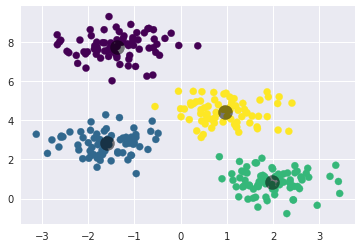

In [3]:
kmeans = KMeans(n_clusters=4) 
kmeans.fit(X) 
y_kmeans = kmeans.predict(X)

# 用带彩色标签的数据来展示聚类结果
# 画出簇中心点，这些簇中心点是由k-means评估器确定
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_ 
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

你可能会好奇，这些算法究竟是如何快速找到这些簇的，毕竟可能存在的簇分配组合方案会随着数据点的增长而呈现指数级增长趋势，穷举搜索需要消耗大量时间。好在有算法可以避免这种穷举搜索，`k-means`方法使用了一种容易理解、便于重复的期望最大化算法取代了穷举搜索。

### 5.11.2 k-means算法：期望最大化
`期望最大化`(expectation-maximization，E-M)是一种非常强大的算法，应用于数据科学的很多场景中。k-means是该算法的一个非常简单并且易于理解的应用。简单来说，`期望最大化`方法包含以下步骤：
1. 猜测一些簇中心点
2. 重复直至收敛
    1. 期望步骤(`E-step`)：将点分配至离其最近的簇中心点
    2. 最大化步骤(`M-step`)：将簇中心点设置为所有点坐标的平均值。

`期望步骤`(E-step或Expectation step)不断更新每个点是属于哪一个簇的期望值，`最大化步骤`(M-step或Maximization step)计算关于簇中心点的拟合函数值最大化对应坐标(argmax函数)。在本例中，通过简单地求每个簇中所有数据点坐标的平均值得到了簇中心点坐标。

关于这个算法的资料非常多，但是这些资料都可以总结为：在典型环境下，每一次重复`E-step`和`M-step`都将会得到更好的聚类效果。

将这个算法在`图5-112`中可视化：
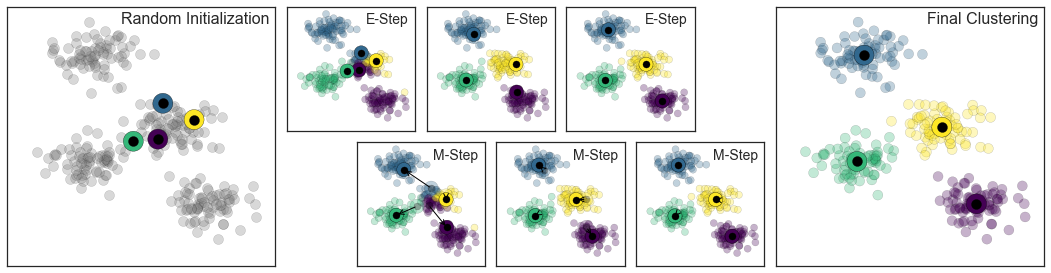

如图所示，数据从初始化状态开始，经过三次迭代后收敛。

`k-means`算法非常简单，以下是一个非常基础的算法实现(`图5-113`)：

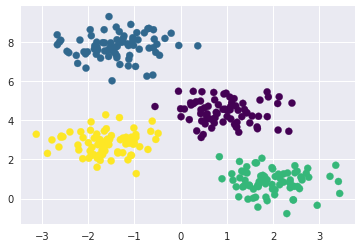

In [4]:
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

虽然大部分可用的聚类算法底层其实都是对上述示例的进一步扩展，但上述函数解释了期望最大化方法的核心内容。

##### 使用期望最大化算法时的注意事项
**可能不会达到全局最优结果**
虽然`E–M算法`可以在每一步中改进结果，但是它并不保证可以获得全局最优的解决方案。例如，如果在上述简单的步骤中使用一个随机种子，那么某些初始值可能会导致很糟糕的聚类结果(`图5-114`)：

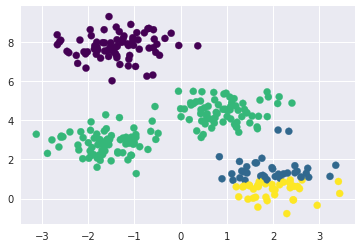

In [5]:
centers, labels = find_clusters(X, 4, rseed=0) 
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

虽然`E–M算法`最终收敛了，但是并没有收敛至全局最优配置。因此，该算法通常会用不同的初始值尝试很多遍，在`Scikit-Learn`中通过`n_init`参数(默认值是`10`)设置执行次数。

**簇数量必须事先定好** `k-means`还有一个显著的问题：你必须告诉该算法簇数量，因为它无法从数据中自动学习到簇的数量。比如我们告诉算法识别出`6`个簇(`图5-115`)：

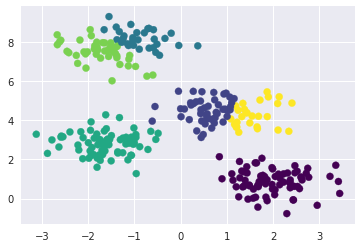

In [6]:
labels = KMeans(6, random_state=0).fit_predict(X) 
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

结果是否有意义很难给出明确回答。有一个非常直观的方法，但这里不会进一步讨论，该方法叫作[轮廓分析](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)。

不过，你也可以使用一些复杂的聚类算法，有些算法对每个簇的聚类效果有更好的度量方式(例如`高斯混合模型`，Gaussian mixture models，参见`5.12`节)，还有一些算法可以选择一个合适的簇数量(例如`DBSCAN`、`均值漂移`或者`近邻传播`，这些都是`sklearn.cluster`的子模块)。

**`k-means`算法只能确定线性聚类边界** `k-means`的基本模型假设(与其他簇的点相比，数据点更接近自己的簇中心点)表明，当簇中心点呈现非线性的复杂形状时，该算法通常不起作用。`k-means`聚类的边界总是线性的。如`图5-116`所示：

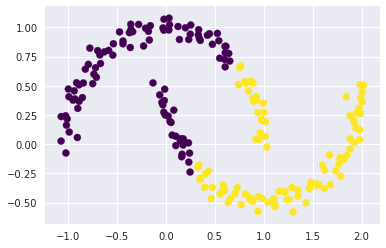

In [7]:
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X) 
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

这个情形让人想起`5.7`节介绍的内容，当时我们通过一个核变换将数据投影到更高维的空间，投影后的数据使线性分离成为可能。可以使用同样的技巧解决`k-means`算法无法处理非线性边界的问题。

`核k-means`算法在`Scikit-Learn`的`SpectralClustering`评估器中实现，它使用`最近邻图`(the graph of nearest neighbors)来计算数据的高维表示，然后用`k-means`算法分配标签(`图5-117`)：

/usr/local/lib/python3.5/dist-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


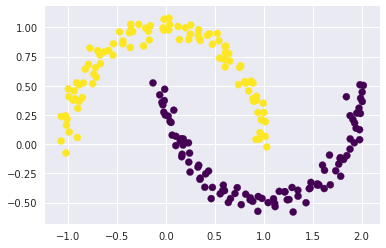

In [8]:
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans') 
labels = model.fit_predict(X) 
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

通过核变换方法，`核k-means`能够找到簇之间复杂的非线性边界了。

**当数据量较大时，`k-means`会很慢** 由于k-means的每次迭代都必须获取数据集所有的点，因此随着数据量的增加，算法会变得缓慢。你可能会想到将`每次迭代都必须使用所有数据点`这个条件放宽，每一步仅使用数据集的一个子集来更新簇中心点。这恰恰就是`批处理`(batch-based)`k-means`算法的核心思想，该算法在`sklearn.cluster.MiniBatchKMeans`中实现。

### 5.11.3 案例
#### 5.11.3.1 案例1：用k-means 算法处理手写数字
我们不使用原始的标签信息，用`k-means`算法识别出类似的数字。这个过程就好像是在事先没有标签信息的情况下，探索新数据集的含义。

手写数字数据集包含`1797`个示例，每个样本有`8×8`个像素，即`64`个特征：

In [9]:
digits = load_digits() 
digits.data.shape

(1797, 64)

In [10]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

需要注意的是，簇中心点本身就是`64`维像素的点，可以将这些点看成是该簇中`具有代表性`的数字，如`图5-118`：

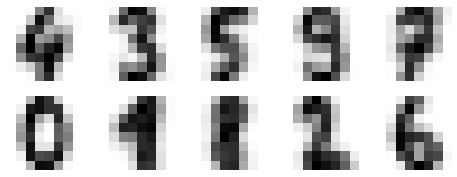

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

plt.show()

即使没有标签，`k-means`算法也可以找到可辨识的数字中心，但是`1`和`8`例外。

由于`k-means`并不知道簇的真实标签，因此`0~9`标签可能并不是顺序排列的。我们可以将每个学习到的簇标签和真实标签进行匹配，从而解决这个问题：

In [12]:
labels = np.zeros_like(clusters) 

for i in range(10):
    mask = (clusters == i) 
    labels[mask] = mode(digits.target[mask])[0]

现在就可以检查无监督聚类算法在查找相似数字时的准确性了：

In [13]:
accuracy_score(digits.target, labels)

0.79354479688369506

再看看混淆矩阵(`图5-119`)：

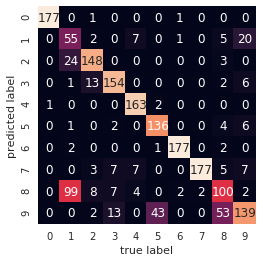

In [14]:
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=digits.target_names, yticklabels=digits.target_names) 
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

正如我们之前看到的簇中心点图，混淆的地方主要是在数字`8`和`1`。但仍然可以看出，`k-means`可以构建一个数字分类器，该数字分类器不需要任何已知的标签。

其实还可以更进一步，使用`t-分布邻域嵌入算法`(参见`5.10`节)在执行`k-means`之前对数据进行预处理。`t-SNE`是一个非线性嵌入算法，特别擅长保留簇中的数据点。下面来看看如何实现：

In [15]:
# 投影数据：这一步将耽误几秒钟 
tsne = TSNE(n_components=2, init='pca', random_state=0) 
digits_proj = tsne.fit_transform(digits.data)

# 计算类 
kmeans = KMeans(n_clusters=10, random_state=0) 
clusters = kmeans.fit_predict(digits_proj)

# 排列标签 
labels = np.zeros_like(clusters) 

for i in range(10):
    mask = (clusters == i) 
    labels[mask] = mode(digits.target[mask])[0]

# 计算准确度 
accuracy_score(digits.target, labels)

0.93711741791875347

同样在没有标签的情况下，它可以达到`94%`的分类准确率，这就是合理使用无监督学习的力量。无监督学习可以从数据集中抽取难以用手眼直接提取的信息。

#### 5.11.3.2 案例2：将k-means用于色彩压缩
聚类算法的另一个有趣应用是图像色彩压缩。设想你有一幅包含几百万种颜色的图像，但其实大多数图像中的很大一部分色彩通常是不会被眼睛注意到的，而且图像中的很多像素都拥有类似或者相同的颜色。

如`图5-120`所示，该图像来源于`Scikit-Learn`的`datasets`模块(在本例需要安装`pillow`图像程序包)：

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


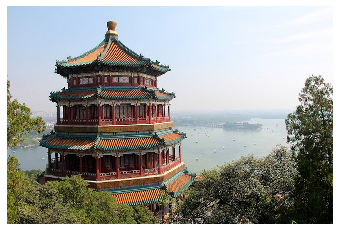

In [16]:
china = load_sample_image("china.jpg") 
ax = plt.axes(xticks=[], yticks=[]) 
ax.imshow(china)
plt.show()

该图像存储在一个三维数组中，以`0~255`的整数表示红、蓝、绿信息：

In [17]:
china.shape

(427, 640, 3)

可以将这组像素转换成三维颜色空间中的一群数据点。先将数据变形为`[n_samples × n_features]`，然后缩放颜色至其取值为`0~1`：

In [18]:
data = china / 255.0 
# 转换成0~1区间值 
data = data.reshape(427 * 640, 3) 
data.shape

(273280, 3)

在颜色空间中对这些像素进行可视化。为了演示方便，这里只使用包含前10000个像素的子集(`图5-121`)：

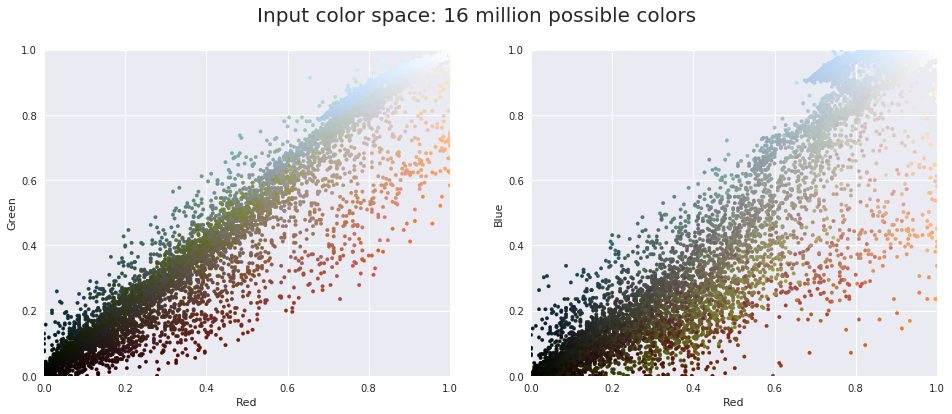

In [19]:
def plot_pixels(data, title, colors=None, N=10000): 
    if colors is None:
        colors = data

    # 随机选择一个子集 
    rng = np.random.RandomState(0) 
    i = rng.permutation(data.shape[0])[:N] 
    colors = colors[i] 
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6)) 
    ax[0].scatter(R, G, color=colors, marker='.') 
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    ax[1].scatter(R, B, color=colors, marker='.') 
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    fig.suptitle(title, size=20)

plot_pixels(data, title='Input color space: 16 million possible colors')
plt.show()

现在对像素空间(特征矩阵)使用`k-means`聚类，将`1600万`种颜色(`255 × 255 × 255 = 16581375`)缩减到`16`种颜色。因为我们处理的是一个非常大的数据集，所以使用`MiniBatchKMeans`算法对数据集的子集进行计算(`图5-122`)：

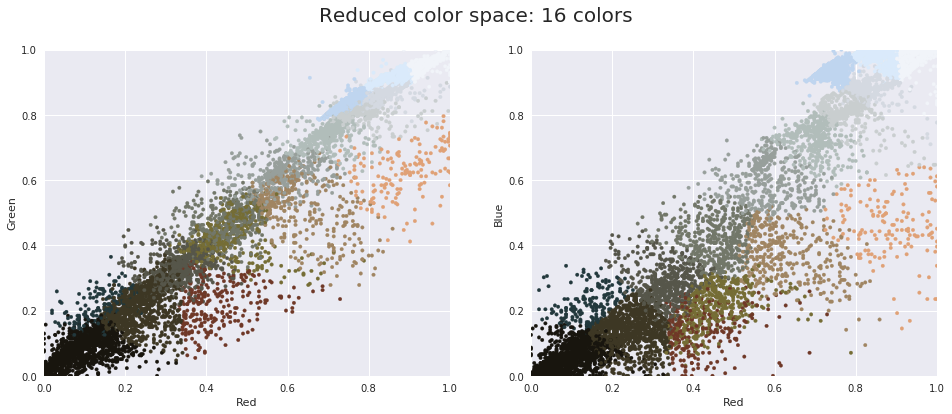

In [20]:
kmeans = MiniBatchKMeans(16) 
kmeans.fit(data) 
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")
plt.show()

用计算的结果对原始像素重新着色，即每个像素被指定为距离其最近的簇中心点的颜色。用新的颜色在图像空间`427 × 640`，而不是像素空间`273280 × 3`里重新画图(`如图5-123`)：

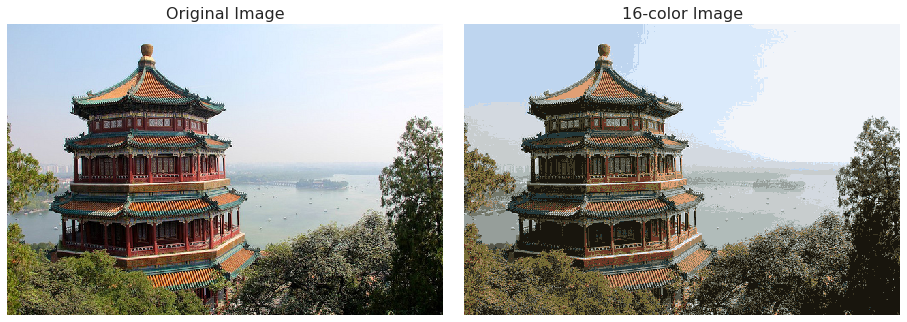

In [21]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), 
                       subplot_kw=dict(xticks=[], yticks=[])) 
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)

plt.show()

虽然右图丢失了某些细节，但是图像总体上还是非常容易辨识的。右图实现了将近一百万的压缩比！这就是`k-means`的一个有趣的应用，当然还有很多更好的压缩图像的算法，但是这个示例足以显示无监督算法解决问题的力量。